In [1]:
import os

import numpy as np
import pandas as pd
from root_pandas import read_root
import root_numpy

import matplotlib.pyplot as plt

from sklearn.cross_validation import train_test_split, cross_val_score
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

import xgboost as xgb

from itertools import islice

from tqdm import tqdm

import ROOT

from scripts.data_preparation import read_and_select

from rep.metaml import GridOptimalSearchCV, RegressionParameterOptimizer

# Requirements
## bam (our interactive machines)
If you use `zsh`, on one of the machines:
```bash
# activate the miniconda environment
cd /opt/rh/miniconda/envs/py3root6 && source /opt/rh/miniconda/scripts/py3root6.sh && cd -
# install dependencies
pip install --user xgboost rep tqdm
# run jupyter (maybe inside a tmux session?)
jupyter notebook --no-browser --port 61337
```
You can connect to the notbebook by forwarding the remote port to your local machine like
```bash
ssh -N -f -L "8888:[::1]:61337" bam
```
The notebook will be available at [localhost:8888](http://localhost:8888). Note that the quotes are only neccessary, if `[]` is special sytax in your shell.

## lxplus
To be added... see the [LHCb Starterkit: Install Party](https://lhcb.github.io/first-analysis-steps/18-install-party.html) for a starting point.

In [2]:
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (12, 7)
plt.rcParams['font.size'] = 14

# Read in Data from `/net/storage`

In [9]:
data_dir = '/home/kheinicke/tank/flavourtagging/'
filenames = [
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MD_sweighted_kheinick.root',
    data_dir + 'Bu2JpsiK_MuonTrainingTuple_2012_MU_sweighted_kheinick.root',
]
chunksize = 10000

In [10]:
data_kwargs = dict(
    key='DecayTree',
    columns=['B_OS_Muon*', 'B_*', 'SigYield_sw', 'BkgYield_sw'],
    ignore=['B_ENDVERTEX_COV_',
         'B_OWNPV_COV_',
         'B_TOPPV_COV_',
         'B_OS_E*',
         'B_OS_K*',
         'B_All*',
         'B_Hlt*',
         'B_L0*',
        ],
    chunksize=chunksize,
    where='(B_LOKI_MASS_JpsiConstr_NoPVConstr>0)',
    flatten=True
)

In [11]:
# still have to use plain ROOT to get the number of entries...
n_entries = 0
for fn in filenames:
    f = ROOT.TFile(fn)
    t = f.Get('DecayTree')
    n_entries += t.GetEntries()

In [ ]:
df = read_and_select(read_root(filenames, **data_kwargs),
                'B_OS_Muon_P > 0'
                '& B_OS_Muon_PT > 0.5'
                '& B_OS_Muon_IsSignalDaughter == 0'
                '& B_OS_Muon_phiDistance > 0.005'
                '& B_OS_Muon_MuonPIDIsMuon == 1'
                '& B_OS_Muon_TRCHI2DOF < 3'
                '& B_OS_Muon_RecVertexIP > 0'
                '& B_OS_Muon_TRGHP < 0.4'
                '& B_OS_Muon_PROBNNmu > 0.35'
                '& B_OS_Muon_PROBNNpi < 0.8'
                '& B_OS_Muon_PROBNNe < 0.8'
                '& B_OS_Muon_PROBNNk < 0.8'
                '& B_OS_Muon_PROBNNp < 0.8',
                chunksize=chunksize,
                max_rows=1000000,
                n_entries=n_entries)

  1%|          | 5850/1000000 [01:21<3:52:47, 71.18it/s]

In [6]:
if os.path.isfile('muon_max_pt_dataset.root'):
    full_data = root_pandas.read_root('muon_max_pt_dataset.root')
else:
    # update code!

# Define the classic muon tagger features and prepare the training dataset

In [193]:
classic_MVA_features = [
    'B_OS_Muon_countTracks',  # aka mult
    'B_OS_Muon_P',
    'B_OS_Muon_PT',
    'B_PT',
    'B_OS_Muon_ABS_RecVertexIP',  # aka IPs
    'B_OS_Muon_TRCHI2DOF',
    'B_OS_Muon_PROBNNmu',
    'B_OS_Muon_TRGHP',
    'B_OS_Muon_IPPUs',
]

all_muon_features = [c for c in full_data.columns if c.startswith('B_OS_Muon')] + ['B_PT']

In [435]:
classic_data = full_data[all_muon_features + ['target', 'SigYield_sw', 'B_ID']].copy(deep=True)
labels = full_data.target

In [436]:
classic_data.replace([np.inf], 10000, inplace=True)
classic_data.dropna(inplace=True)

In [437]:
# /= 1000 somehow kills the kernel. Maybe a bug in pandas?
classic_data.B_PT *= 0.001
classic_data.B_OS_Muon_P *= 0.001
classic_data.B_OS_Muon_PT *= 0.001

# Apply Muon Selections

In [438]:
before = len(classic_data)
classic_data = classic_data[
    (classic_data.B_OS_Muon_P > 0)
    & (classic_data.B_OS_Muon_PT > 0.5)
    & (classic_data.B_OS_Muon_IsSignalDaughter == 0)
#    & (classic_data.B_OS_Muon_phiDistance > 0.005)
    & (classic_data.B_OS_Muon_MuonPIDIsMuon == 1)
    & (classic_data.B_OS_Muon_TRCHI2DOF < 3)
    & (classic_data['B_OS_Muon_BPVIPCHI2()'] > 0)
    & (classic_data.B_OS_Muon_RecVertexIP > 0)
    & (classic_data.B_OS_Muon_TRGHP < 0.4)
    & (classic_data.B_OS_Muon_PROBNNmu > 0.35)
    & (classic_data.B_OS_Muon_PROBNNpi < 0.8)
    & (classic_data.B_OS_Muon_PROBNNe < 0.8)
    & (classic_data.B_OS_Muon_PROBNNk < 0.8)
    & (classic_data.B_OS_Muon_PROBNNp < 0.8)
#    & (classic_data.SigYield_sw > 0)
]
efficiency = len(classic_data) / before
labels = classic_data.target

print('Efficiency {:2.1f}%'.format(100 * efficiency))

Efficiency 0.6%


In [440]:
print(full_data.shape)
print(classic_data.shape)

(850118, 109)
(5105, 34)


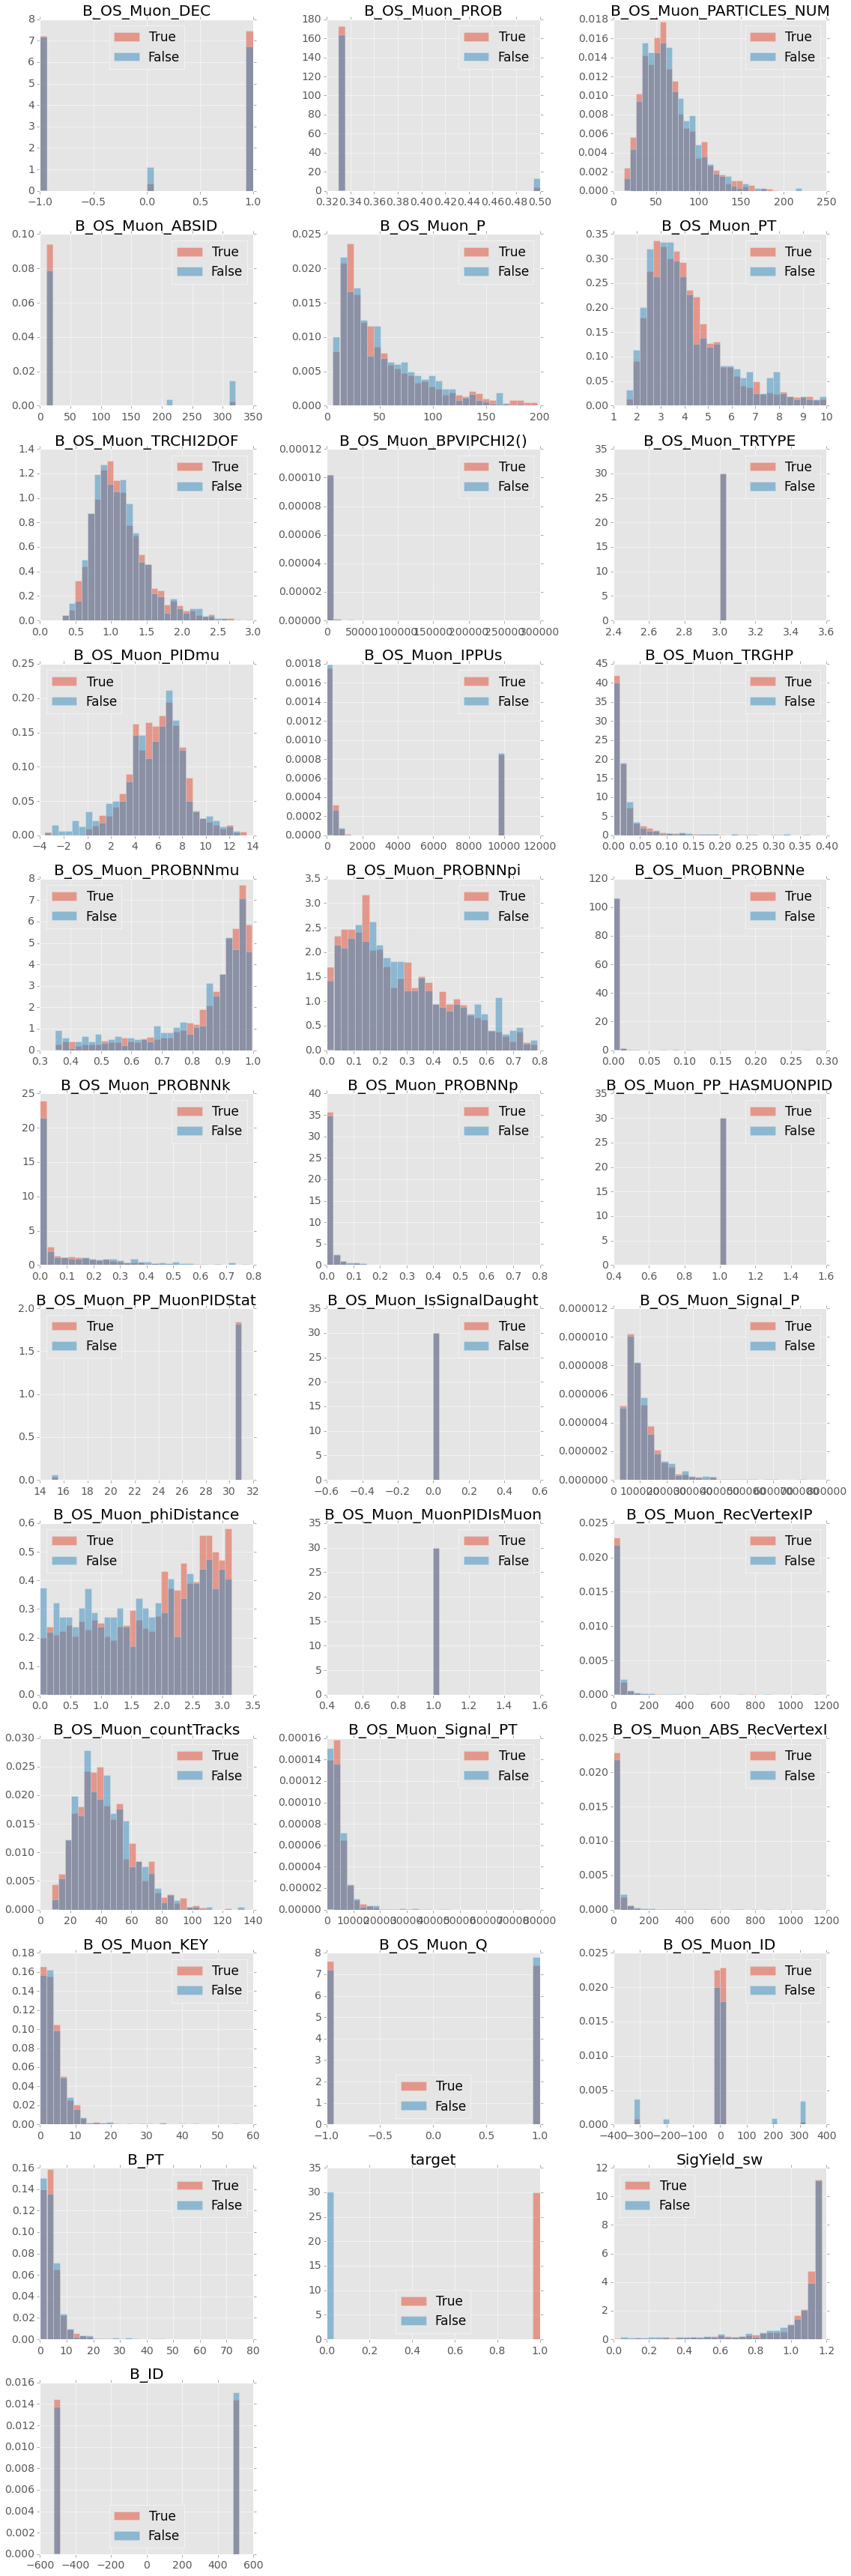

In [199]:
ncols = 3
nrows = np.ceil(len(classic_data.columns)/ncols)
plt.figure(figsize=(16, nrows * 4))
for i, f in enumerate(classic_data.columns):
    plt.subplot(nrows, ncols, i+1)
    _, bins = np.histogram(classic_data[f], 30)
    classic_data[labels==True][f].hist(bins=bins, alpha=0.5, label='True', normed=True)
    classic_data[labels==False][f].hist(bins=bins, alpha=0.5, label='False', normed=True)
    plt.title(f[:24])
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

# Train some Classifiers

In [441]:
def avg_dilution(labels, prediction, threshhold=0.5):
    wrong_tags = labels != (prediction > threshhold)
    omega = np.sum(wrong_tags) / len(labels)
    return 1 - 2*omega

In [448]:
train_data, test_data, train_labels, test_labels = train_test_split(classic_data, labels, test_size=0.3, random_state=1)

In [443]:
xgboost_model = xgb.XGBClassifier(seed=1)

In [459]:
xgboost_model.fit(train_data[classic_MVA_features][train_data.SigYield_sw > 0], train_labels[train_data.SigYield_sw > 0])

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=1, silent=True, subsample=1)

In [462]:
mistag_prob, correcttag_prob = xgboost_model.predict_proba(test_data[classic_MVA_features]).T
probas = correcttag_prob
preds = xgboost_model.predict(test_data[classic_MVA_features])
score = roc_auc_score(test_labels, probas, sample_weight=test_data.SigYield_sw)

In [463]:
print(score)

0.56172180027


In [205]:
gb = GradientBoostingClassifier()
gb.fit(train_data[classic_MVA_features], train_labels)

GradientBoostingClassifier(init=None, learning_rate=0.1, loss='deviance',
              max_depth=3, max_features=None, max_leaf_nodes=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [206]:
gb_probas = gb.predict_proba(test_data[classic_MVA_features])[:,1]
gb_score = roc_auc_score(test_labels, gb_probas)

In [207]:
rf = RandomForestClassifier(n_estimators=30)
rf.fit(train_data[classic_MVA_features], train_labels)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=30, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [208]:
rf_probas = rf.predict_proba(test_data[classic_MVA_features])[:,1]
rf_score = roc_auc_score(test_labels, rf_probas)

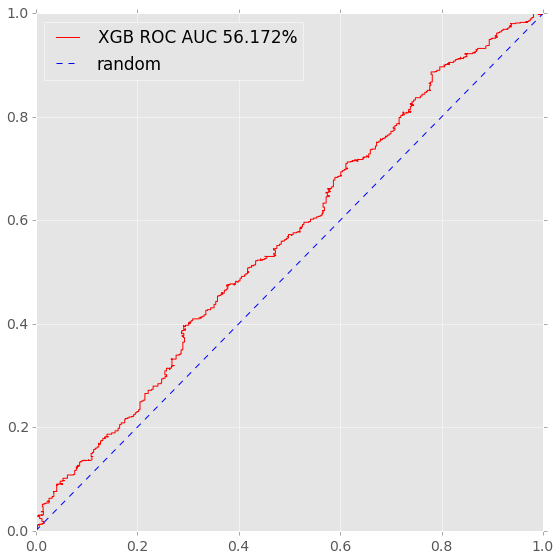

In [482]:
plt.figure(figsize=(8, 8))
plt.plot(*roc_curve(test_labels, probas, sample_weight=test_data.SigYield_sw)[:2], label='XGB ROC AUC {:2.3f}%'.format(score * 100))
# plt.plot(*roc_curve(test_labels, gb_probas)[:2], label='GB ROC AUC {:2.3f}%'.format(score * 100))
# plt.plot(*roc_curve(test_labels, rf_probas)[:2], label='RF ROC AUC {:2.3f}%'.format(rf_score * 100))
plt.plot([0, 1], '--', label='random')
plt.legend(loc='best')
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.tight_layout()
plt.savefig('build/roc_auc.pdf')
plt.show()

In [471]:
print('eps_eff_avg = {:2.3f}%'.format(100 * efficiency * avg_dilution(test_labels, probas)**2))

eps_eff_avg = 0.087%


In [485]:
from IPython.display import FileLink
b = gbm.booster()  # This is the underlying XGBoost model
b.save_model('trained_model.xgb')  # it can easily be stored to disk
FileLink('trained_model.xgb', result_html_prefix='Download here: ')

/home/kheinicke/repos/fttrainer/trained_model.xgb

# Also look at other FOMs

In [474]:
def tagging_power(efficiency, dilution):
    return efficiency * dilution ** 2


def tagging_power_scorer(estimator, X, y):
    probas = estimator.predict_proba(X)[:,1]
    dilution = avg_dilution(y, probas)
    return tagging_power(efficiency, dilution)


def tp_scorer(y_true, probas, sample_weight=None):
    dilution = avg_dilution(y_true, probas)
    return tagging_power(efficiency, dilution)


def tagging_power_curve(y_true, probas):
    xs = np.linspace(0, 1, 100)
    ys = [tagging_power(efficiency, avg_dilution(y_true, probas, thresh)) for thresh in xs]
    return np.array(ys), xs

### Just to keep in mind

#### ROC AUC
Area under ROC Curve. Which is plotting true positive rate tpr against false positive rate fpr.

#### Tagging Power
$$
\varepsilon_\text{eff} = \varepsilon\cdot (1 - 2\overline\eta)^2 \qquad \text{(?)}
$$
With

- $\varepsilon$: Selection efficiency
- Dilution $D = (1 - 2\overline{\eta})$
- $\overline{\eta} = \frac{\mathrm{fp}}{\mathrm{ALL}}$ average mistag probability

#### Precision (Reinheit)
$$
\frac{\mathrm{tp}}{\mathrm{tp} + \mathrm{fp}}
$$

#### Recall (Effizienz)
$$
\frac{\mathrm{tp}}{\mathrm{tp} + \mathrm{fn}}
$$

In [475]:
scores = {
    'ROC_AUC': {
        'scorer': 'roc_auc',
        'results': [],
    },
    'tagging_power': {
        'scorer': tagging_power_scorer,
        'results': [],
    },
    'precision': {
        'scorer': 'precision',
        'results': [],
    },
    'recall': {
        'scorer': 'recall',
        'results': [],
    },
}

In [ ]:
cv_xgb_model = xgb.XGBClassifier(nthread=1)
for name, setup in scores.items():
    scorer = setup['scorer']
    result = setup['results']
    result = cross_val_score(cv_xgb_model,
                             classic_data[classic_MVA_features],
                             labels, cv=10, n_jobs=10,
                             scoring=scorer)
    print('{} {:2.2f}±{:2.2f}%'.format(
            name,
            100 * result.mean(),
            100 * result.std()))

recall 98.16±0.72%


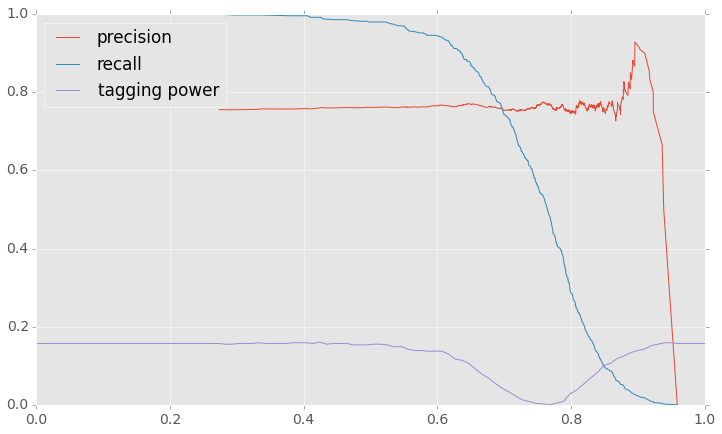

In [302]:
plt.plot(precision_recall_curve(test_labels, probas)[2], precision_recall_curve(test_labels, probas)[0][:-1], label='precision')
plt.plot(precision_recall_curve(test_labels, probas)[2], precision_recall_curve(test_labels, probas)[1][:-1], label='recall')
plt.plot(tagging_power_curve(test_labels, probas)[1], 100 * tagging_power_curve(test_labels, probas)[0], label='tagging power')
plt.legend(loc='best')
plt.show()